In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# 메트플로립세팅
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # still experimental 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder  # scikit-learn과 호환됨
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import set_config

import optuna

ModuleNotFoundError: No module named 'category_encoders'

## 이상치 제거 함수

In [3]:
def get_outlier(df=None, column=None, weight=1.5):
    import numpy as np
    age_group_list = [20,30,40,50,60,70]
    outlier_index_set = set()
    
    
    for age_group in age_group_list:
        # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
        fraud = df[df['연령대_1']==age_group][column]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight
        # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
        outlier_index_set = outlier_index_set | set(fraud[(fraud < lowest_val) | (fraud > highest_val)].index)
        
    return outlier_index_set

def remove_outlier(df=None,column_list=None,weight=1.5):
    outlier_index_set = set()
    
    for column_name in column_list:
        outlier_index = get_outlier(df=df, column=column_name, weight=weight)
        outlier_index_set = outlier_index_set | outlier_index
        
    df.drop(list(outlier_index_set), inplace=True)
    df.reset_index(drop=True, inplace=True)


## 통신데이터 컬럼 드랍 및 데이터 프레임 만들기

In [4]:
for m in tqdm(range(1,10),desc='월단위 진행'):
    globals()["ts{}".format(m)] = pd.read_csv(f'./data/2022.{m}월_29개 통신정보.csv',encoding='cp949')
    try : 
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동','총인구수','1인가구수'],inplace=True)    
    except:
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동명','총인구','1인가구수'],inplace=True)  
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='4분위수'),inplace=True)
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='인구'),inplace=True) #미추정
    
    # 데이터가 평균값을 제시하고 그 외 4분위 관련 수치를 따로 제공해주고 있음 -> 이미 전처리가 되어있는 거 같음..?
    globals()["ts{}".format(m)]['연령대_1'] = globals()["ts{}".format(m)]['연령대']//10*10
    globals()["ts{}".format(m)]['월'] = int(m)
    fix = globals()["ts{}".format(m)][['월','연령대','연령대_1','자치구','성별']]
    uni = ['상주지','출근','근무','소액결재','연체','카카오톡','SNS','통화','문자','데이터','이동','체류','지하철','게임','금융','쇼핑','동영상','유튜브','넷플릭스','배달']
    
    for col in tqdm(uni,desc=f'{m}월'):
        globals()["{}_{}".format(col,m)] = pd.concat([fix,globals()["ts{}".format(m)].filter(like=col)],axis=1)    
        
        
for col in tqdm(uni,desc='카테고리별로 합치기'):
    globals()["{}".format(col)] = pd.DataFrame()
    for m in range(1,10):
        globals()["이동_{}".format(m)].drop(columns= globals()["이동_{}".format(m)].filter(like='지하철'),inplace=True)
        globals()["{}".format(col)]= pd.concat([globals()["{}".format(col)],globals()["{}_{}".format(col,m)]])

월단위 진행:   0%|          | 0/9 [00:00<?, ?it/s]

1월:   0%|          | 0/20 [00:00<?, ?it/s]

2월:   0%|          | 0/20 [00:00<?, ?it/s]

3월:   0%|          | 0/20 [00:00<?, ?it/s]

4월:   0%|          | 0/20 [00:00<?, ?it/s]

5월:   0%|          | 0/20 [00:00<?, ?it/s]

6월:   0%|          | 0/20 [00:00<?, ?it/s]

7월:   0%|          | 0/20 [00:00<?, ?it/s]

8월:   0%|          | 0/20 [00:00<?, ?it/s]

9월:   0%|          | 0/20 [00:00<?, ?it/s]

카테고리별로 합치기:   0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
df = pd.concat([ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9],axis=0,ignore_index=True)

df

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
0,종로구,1,20,2.6,3.8,56.6,514.9,1.7,7333.3,4.81,...,82.8,72.1,28.0,0.3,-0.1,10.3,2.5,1.7,20,1
1,종로구,1,25,2.3,3.7,50.3,527.0,2.3,9486.1,12.50,...,109.3,103.6,31.2,0.2,-0.1,13.9,3.0,1.7,20,1
2,종로구,1,30,2.2,3.1,57.4,532.4,2.7,7071.4,9.88,...,130.2,121.7,30.1,0.1,-0.1,13.8,3.2,1.7,30,1
3,종로구,1,35,2.0,2.7,61.6,540.8,2.4,7072.9,11.95,...,123.2,121.4,28.1,0.1,-0.2,11.2,3.3,1.7,30,1
4,종로구,1,40,1.9,2.6,69.3,554.7,2.8,5655.2,4.62,...,122.2,118.0,28.9,0.0,-0.2,9.3,3.1,1.7,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91579,강동구,2,55,1.5,2.7,56.7,502.5,2.3,6623.8,6.68,...,61.5,96.0,15.1,-0.1,-0.6,9.6,3.6,1.7,50,9
91580,강동구,2,60,1.5,2.8,60.8,486.8,2.6,6711.4,6.55,...,45.5,68.0,13.9,-0.1,-0.6,8.9,3.6,1.7,60,9
91581,강동구,2,65,1.4,2.8,60.1,451.1,2.7,6420.3,3.86,...,36.6,52.6,12.5,-0.2,-0.6,7.6,4.2,1.7,60,9
91582,강동구,2,70,1.3,1.4,20.0,520.0,2.8,7051.3,4.49,...,26.2,36.4,10.2,-0.3,-0.6,5.2,0.0,1.7,70,9


In [6]:
df.isnull().sum()

자치구                  0
성별                   0
연령대                  0
야간상주지 변경횟수 평균        0
주간상주지 변경횟수 평균        0
평균 출근 소요시간 평균        0
평균 근무시간 평균           0
소액결재 사용횟수 평균         0
소액결재 사용금액 평균         0
최근 3개월 내 요금 연체 비율    0
SNS 사용횟수             0
평균 통화량               0
평균 문자량               0
평균 통화대상자 수           0
평균 문자대상자 수           0
데이터 사용량              0
평일 총 이동 횟수           0
휴일 총 이동 횟수 평균        0
집 추정 위치 평일 총 체류시간    0
집 추정 위치 휴일 총 체류시간    0
평일 총 이동 거리 합계        0
휴일 총 이동 거리 합계        0
지하철이동일수 합계           0
게임 서비스 사용일수          0
금융 서비스 사용일수          0
쇼핑 서비스 사용일수          0
동영상/방송 서비스 사용일수      0
유튜브 사용일수             0
넷플릭스 사용일수            0
배달 서비스 사용일수          0
배달_브랜드 서비스 사용일수      0
배달_식재료 서비스 사용일수      0
연령대_1                0
월                    0
dtype: int64

In [7]:
col_lst = df.columns[5:]
col_= [x for x in col_lst ]
col_

['평균 출근 소요시간 평균',
 '평균 근무시간 평균',
 '소액결재 사용횟수 평균',
 '소액결재 사용금액 평균',
 '최근 3개월 내 요금 연체 비율',
 'SNS 사용횟수',
 '평균 통화량',
 '평균 문자량',
 '평균 통화대상자 수',
 '평균 문자대상자 수',
 '데이터 사용량',
 '평일 총 이동 횟수',
 '휴일 총 이동 횟수 평균',
 '집 추정 위치 평일 총 체류시간',
 '집 추정 위치 휴일 총 체류시간',
 '평일 총 이동 거리 합계',
 '휴일 총 이동 거리 합계',
 '지하철이동일수 합계',
 '게임 서비스 사용일수',
 '금융 서비스 사용일수',
 '쇼핑 서비스 사용일수',
 '동영상/방송 서비스 사용일수',
 '유튜브 사용일수',
 '넷플릭스 사용일수',
 '배달 서비스 사용일수',
 '배달_브랜드 서비스 사용일수',
 '배달_식재료 서비스 사용일수',
 '연령대_1',
 '월']

In [8]:
remove_outlier(df,col_)
df

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
0,종로구,1,25,2.3,3.7,50.3,527.0,2.3,9486.1,12.50,...,109.3,103.6,31.2,0.2,-0.1,13.9,3.0,1.7,20,1
1,종로구,1,30,2.2,3.1,57.4,532.4,2.7,7071.4,9.88,...,130.2,121.7,30.1,0.1,-0.1,13.8,3.2,1.7,30,1
2,종로구,1,35,2.0,2.7,61.6,540.8,2.4,7072.9,11.95,...,123.2,121.4,28.1,0.1,-0.2,11.2,3.3,1.7,30,1
3,종로구,1,40,1.9,2.6,69.3,554.7,2.8,5655.2,4.62,...,122.2,118.0,28.9,0.0,-0.2,9.3,3.1,1.7,40,1
4,종로구,1,45,1.8,2.5,71.1,530.8,2.5,7657.3,7.42,...,95.3,115.6,24.9,-0.1,-0.3,8.5,3.0,1.7,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62849,강동구,2,50,1.5,2.7,62.2,508.7,2.3,7943.0,8.22,...,81.9,134.6,18.7,-0.1,-0.5,10.8,3.1,1.7,50,9
62850,강동구,2,55,1.5,2.7,56.7,502.5,2.3,6623.8,6.68,...,61.5,96.0,15.1,-0.1,-0.6,9.6,3.6,1.7,50,9
62851,강동구,2,60,1.5,2.8,60.8,486.8,2.6,6711.4,6.55,...,45.5,68.0,13.9,-0.1,-0.6,8.9,3.6,1.7,60,9
62852,강동구,2,65,1.4,2.8,60.1,451.1,2.7,6420.3,3.86,...,36.6,52.6,12.5,-0.2,-0.6,7.6,4.2,1.7,60,9


In [9]:
# 데이터셋 확인을 위한 써머리 함수
def resumetable(df):
    print(f'데이터셋 확인: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측치'] = df.isnull().sum().values
    summary['범주'] = df.nunique().values
    summary['1st_value'] = df.iloc[0].values
    summary['2nd_value'] = df.iloc[1].values
    summary['3rd_value'] = df.iloc[2].values
    summary['4th_value'] = df.iloc[3].values
    summary['5th_value'] = df.iloc[4].values
    
    return summary

In [10]:
resumetable(df)

데이터셋 확인: (62854, 34)


,피처,데이터 타입,결측치,범주,1st_value,2nd_value,3rd_value,4th_value,5th_value
0,자치구,object,0,25,종로구,종로구,종로구,종로구,종로구
1,성별,int64,0,2,1,1,1,1,1
2,연령대,int64,0,12,25,30,35,40,45
3,야간상주지 변경횟수 평균,float64,0,21,2.3,2.2,2.0,1.9,1.8
4,주간상주지 변경횟수 평균,float64,0,38,3.7,3.1,2.7,2.6,2.5
5,평균 출근 소요시간 평균,float64,0,485,50.3,57.4,61.6,69.3,71.1
6,평균 근무시간 평균,float64,0,1685,527.0,532.4,540.8,554.7,530.8
7,소액결재 사용횟수 평균,float64,0,18,2.3,2.7,2.4,2.8,2.5
8,소액결재 사용금액 평균,float64,0,24330,9486.1,7071.4,7072.9,5655.2,7657.3
9,최근 3개월 내 요금 연체 비율,float64,0,2904,12.5,9.88,11.95,4.62,7.42


<font color="#CC3D3D"><p>
# Building a `LightGBM` Model with `Pipeline+Optuna`

In [11]:
LGBM_VERSION = 1.0   # submission 

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV
from optuna.integration.lightgbm import LightGBMTunerCV

ModuleNotFoundError: No module named 'optuna'

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement oputna (from versions: none)
ERROR: No matching distribution found for oputna


#### Split data

In [15]:
target='연령대'
    
X = df.copy().drop(columns=target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50283 entries, 28095 to 47437
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   자치구                50283 non-null  object 
 1   성별                 50283 non-null  int64  
 2   야간상주지 변경횟수 평균      50283 non-null  float64
 3   주간상주지 변경횟수 평균      50283 non-null  float64
 4   평균 출근 소요시간 평균      50283 non-null  float64
 5   평균 근무시간 평균         50283 non-null  float64
 6   소액결재 사용횟수 평균       50283 non-null  float64
 7   소액결재 사용금액 평균       50283 non-null  float64
 8   최근 3개월 내 요금 연체 비율  50283 non-null  float64
 9   SNS 사용횟수           50283 non-null  float64
 10  평균 통화량             50283 non-null  float64
 11  평균 문자량             50283 non-null  float64
 12  평균 통화대상자 수         50283 non-null  float64
 13  평균 문자대상자 수         50283 non-null  float64
 14  데이터 사용량            50283 non-null  float64
 15  평일 총 이동 횟수         50283 non-null  float64
 16  휴일 총 이동 횟수 평균     

In [17]:
X_train.head()

,자치구,성별,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,SNS 사용횟수,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
28095,영등포구,1,1.9,2.6,61.5,572.0,2.3,6561.6,20.11,0.2,...,139.3,150.8,31.3,0.1,-0.2,14.7,4.1,1.7,30,4
31069,성동구,2,1.8,1.5,0.0,0.0,0.0,0.0,3.75,-0.2,...,20.3,29.8,8.5,-0.3,-0.6,12.5,1.7,0.0,70,5
3100,은평구,2,1.5,2.5,65.4,480.4,2.4,8300.8,5.39,0.0,...,48.4,58.5,12.8,-0.1,-0.6,10.0,3.3,1.7,60,1
7670,종로구,2,2.3,3.6,64.1,519.0,2.1,8272.7,9.55,0.0,...,76.7,100.7,22.5,0.2,-0.1,13.4,2.1,1.7,20,2
45208,강동구,2,1.5,1.3,0.0,0.0,2.8,9666.7,4.31,-0.2,...,23.6,25.9,8.6,-0.4,-0.7,13.6,1.7,1.7,70,6


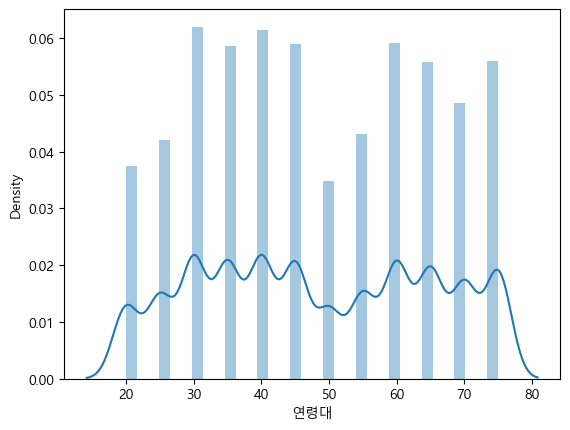

In [18]:
sns.distplot(y_train); plt.show()

#### 수치형/범주형 피처 분리

In [19]:
X_train.columns

Index(['자치구', '성별', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량',
       '평일 총 이동 횟수', '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수',
       '연령대_1', '월'],
      dtype='object')

In [20]:
numeric_features = ['성별', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량',
       '평일 총 이동 횟수', '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수',
       '연령대_1', '월']
categorical_features = ['자치구']

X_train = X_train[numeric_features+categorical_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features]

####  파이프라인 구축

In [21]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})), 
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=80)),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LGBMRegressor(random_state=0)),
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('outlier',
                                                                                    FunctionTransformer(func=<function remove_outlier at 0x0000024B042DAF70>,
                                                                                                        kw_args={'q': 0.05})),
                                                                                   ('scaler',
                                                                                    PowerTransformer())]),
                                                                   ['성별',
                                                                    '야간상주지 '
                                                                    '변경횟수 평균',
                                                                    '주간상주지 '
                                                                    '변경횟수 평균',
                                                                    '평균 출근 '
                                                                    '소요시간 평균',
                                                                    '평균 근무시간 '
                                                                    '평균',
                                                                    '소액결재 사용횟수...
                                                                    '유튜브 사용일수',
                                                                    '넷플릭스 사용일수',
                                                                    '배달 서비스 '
                                                                    '사용일수',
                                                                    '배달_브랜드 '
                                                                    '서비스 사용일수',
                                                                    '배달_식재료 '
                                                                    '서비스 사용일수', ...]),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OrdinalEncoder(dtype=<class 'int'>,
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['자치구'])])),
                                 ('selector',
                                  SelectPercentile(percentile=80))])),
                ('classifier', LGBMRegressor(random_state=0))])

#### LGBM Baseline 성능 확인

In [22]:
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

print("Default LGBM CV scores: ", np.sqrt(-1*scores))
print("Default LGBM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

Default LGBM CV scores:  [0.96203888 0.95822477 0.95374401 0.71837112 0.9429168 ]
Default LGBM CV mean = 0.91 with std = 0.40


#### LGBM 하이퍼파라미터 최적화
- 1단계) 전처리 파라미터 최적값 탐색: OptunaSearchCV를 통해 전처리 관련 최적의 파라미터을 찾음 (LGBM은 No Tuning)

In [25]:
%%time

param_distributions = {
    "preprocessor__column__num__imputer__strategy": CategoricalDistribution(["mean","median"]),
    "preprocessor__column__num__outlier__kw_args": CategoricalDistribution([{'q':0.01},{'q':0.05},{'q':0.1}]),
    "preprocessor__selector__percentile": IntDistribution(50,100,step=10),  
}

optuna_search = OptunaSearchCV(model, 
                               param_distributions, 
                               cv=5, scoring='neg_mean_squared_error', 
                               n_trials=10,
                               study=optuna.create_study(sampler=optuna.samplers.TPESampler(seed=100), direction="maximize"))

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search.fit(X_train, y_train)

print(f"Best params: {optuna_search.best_params_}")
print("Best score: %.2f" % (-1*optuna_search.best_score_)**0.5)

NameError: name 'CategoricalDistribution' is not defined

- 2단계) 전처리 최적화 수행: 최적의 파라미터 값으로 파이프라인 재설정

In [24]:
# 최적값으로 파이프라인 재설정
model.set_params(**optuna_search.best_params_)

# 전처리 파이프라인만 수행
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

NameError: name 'optuna_search' is not defined

- 3단계) LGBM 모형 최적화: Optuna의 LightGBMTunerCV을 통한 하이퍼파라미터 최적화

In [ ]:
tuner = LightGBMTunerCV(
    params={
        "objective": "regression",   # 지도학습 유형(regression/binary/multiclass)
        "metric": "rmse",
        "verbosity": -1,             # 진행과정 출력안함
        "boosting_type": "gbdt",     # 실행하고자 하는 알고리즘 유형(gdbt/rf/dart/goss)
        "seed": 0,
    },
    train_set=lgb.Dataset(X_train, y_train), # LGBM 데이터셋으로 변환
    nfold=5,
    num_boost_round=200,                     # boosting 반복횟수
    callbacks=[lgb.early_stopping(100)],     # 모든 정지 라운드 동안 validation 성능이 개선되지 않으면 조기종료
    time_budget=60,                          # 튜닝 허용 최대시간(초단위)
    optuna_seed=0,
)

tuner.run()

In [ ]:
print(f"\nBest params: {tuner.best_params}")
print(f"\nBest score: {tuner.best_score:.2f}")

In [ ]:
# df = df[['자치구', '성별', '연령대', '연령대_1', '월', '야간상주지 변경횟수 평균',
#        '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균', '평균 근무시간 평균', '소액결재 사용횟수 평균',
#        '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', 'SNS 사용횟수', '평균 통화량', '평균 문자량',
#        '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수', '휴일 총 이동 횟수 평균',
#        '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간', '평일 총 이동 거리 합계',
#        '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수', '금융 서비스 사용일수',
#        '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수', '넷플릭스 사용일수',
#        '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수']]
# # 사용할 컬럼만 뽑아 쓰세요~

In [ ]:
# col_lst = df.columns[5:]
# col_= [x for x in col_lst ]
# col_

In [ ]:
# remove_outlier(df,col_)
# df